<a href="https://colab.research.google.com/github/AhmedNasser1601/GRIP-Task4-Sparks/blob/Main/Task4_Object_Detection_Recognition_%26_ORC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Name: Ahmed Nasser Ahmed Hassan***
**GRIP : *The Sparks Foundation***
> Data Science and Business Analytics Intern
  >> Computer Vision & Internet of Things Task

---
**Task4: *Object Detection Recognition & ORC***
> Keras, TensorFlow, and OpenCV
  >> with non-maxima suppression
---
> [learn more from => **pyimagesearch**](https://pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/#pyis-cta-modal)
---

In [ ]:
!pip install tensorflow==2.2.0

In [ ]:
# Download code.zip from pyimagesearch
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/classifier-to-detector/classifier-to-detector.zip
!unzip -qq classifier-to-detector.zip
%cd classifier-to-detector

In [35]:
import numpy as np
import argparse
import imutils
import time
import cv2

from matplotlib import pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils

from pyimagesearch.detection_helpers import sliding_window
from pyimagesearch.detection_helpers import image_pyramid

from imutils.object_detection import non_max_suppression

### Displaying images in Jupyter & Colab

In [36]:
def plt_imshow(title, image):   # convert BGR -(to)-> RGB color
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implemention of image pyramid & sliding window utility

In [37]:
def sliding_window(image, step, ws):   # Move Window across the image
	for y in range(0, image.shape[0] - ws[1], step):   # cols
		for x in range(0, image.shape[1] - ws[0], step):   # rows
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])   # yield currentWindow

In [38]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	yield image
	
	while True:
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)

		# if the resizedImage doesn't meet the supplied minimum size, then stop building the Pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]: break
		yield image   # yield nextImage in the pyramid



---



## Using Keras and TensorFlow to turn a pre-trained image classifier into an object detector

  >	img1 = "images/stingray.jpg"

  >	img2 = "images/hummingbird.jpg"
  
  >	img3 = "images/lawn_mower.jpg"

In [48]:
# construct the argument and parse it

img1 = "images/stingray.jpg"
img2 = "images/hummingbird.jpg"
img3 = "images/lawn_mower.jpg"

args = {
	"image": img1,
	"size": "(300, 150)",
	"min_conf": 0.9,
	"visualize": -1
}

In [49]:
# initialize variables used for objectDetection
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224)

In [50]:
model = ResNet50(weights="imagenet", include_top=True)   # load networkWeights

# load inputImage, then resize it, then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

In [ ]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)   # initialize imagePyramid

rois = []   # Holding ROIs generated from the imagePyramid and slidingWindow
locs = []   # Storing (x, y) of where the ROI was in the originalImage

start = time.time()
print("Time to loopOver the ImagePyramidLayers and SlidingWindowLocations = {:.5f} sec".format(start))

In [53]:
for image in pyramid:
	scale = W / float(image.shape[1])
 
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		x = int(x*scale)
		y = int(y*scale)
		w = int(ROI_SIZE[0]*scale)
		h = int(ROI_SIZE[1]*scale)
	
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)
	
		rois.append(roi)
		locs.append((x, y, x+w, y+h))
	
		if args["visualize"] > 0:
			# copy originalImage, then draw rectangle surrounding it
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x+w, y+h), (0, 255, 0), 2)

			# visualize and show current_ROI
			plt_imshow("Visualization", clone)
			plt_imshow("ROI", roiOrig)

In [ ]:
end = time.time()
print("Time to loopOver the Pyramid = {:.5f} sec".format(end-start))

rois = np.array(rois, dtype="float32")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("Time to classify ROIs = {:.5f} sec".format(end-start))

preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

In [56]:
for (i, p) in enumerate(preds):
	(imagenetID, label, prob) = p[0]
	
	if prob >= args["min_conf"]:
		box = locs[i]
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L



---



[INFO] showing results for -> lawn_mower image <-



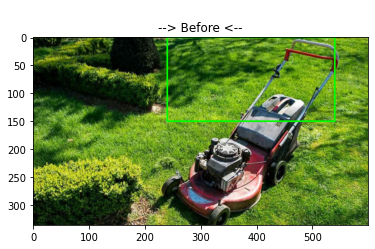

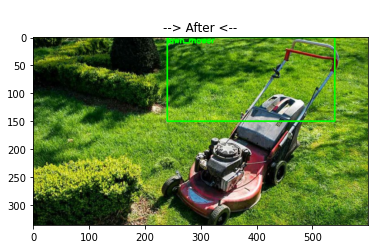







[INFO] showing results for -> wreck image <-



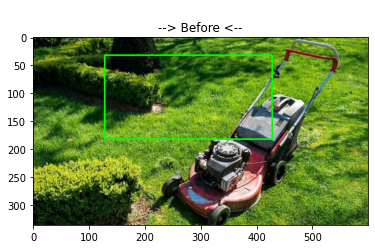

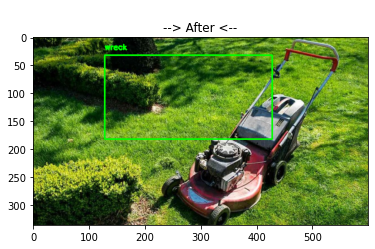







[INFO] showing results for -> scuba_diver image <-



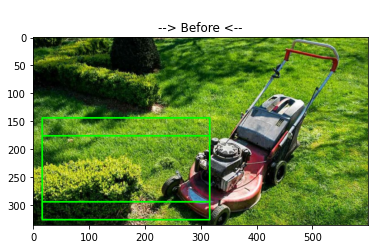

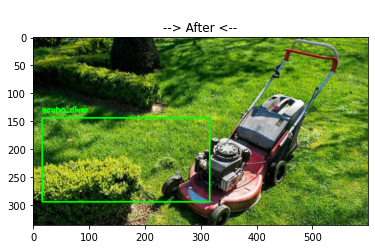

In [60]:
for label in labels.keys():
	print("[INFO] showing results for -> {} image <-\n".format(label))
	clone = orig.copy()

	for (box, prob) in labels[label]:
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
	
	# Show output before -> apply non-maxima suppression
	plt_imshow("\n--> Before <--", clone)
	clone = orig.copy()

  # Extract boxes and associated Prediction-Probabilities
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
 
	boxes = non_max_suppression(boxes, proba)   ##### Apply non-maxima suppression
	
	for (startX, startY, endX, endY) in boxes:
		cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# Show output after -> apply non-maxima suppression
	plt_imshow("\n--> After <--", clone)
 	
	print('\n\n\n\n\n')